# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [3]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)  

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 200.0
l = [np.log(2) / (i * 365) for i in [6.0,  4.0, 2.0]]
d = {
    l[0]: "6yrs half-life",
    l[1]: "4yrs half-life",
    l[2]: "2yrs half-life",
}
df['decay_rate'] = df['staking_rewards_vesting_decay_rate'].map(d)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " max_rate=" + df["release_rate_max"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

10643400

In [4]:
base_df = df[df["token_scenario"]=="base"]
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]
combined_df["combined_scenario"] = combined_df["staking_scenario"]

## 3. Reward sources

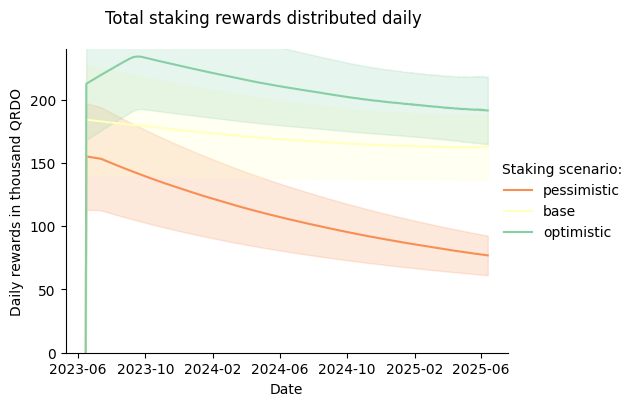

In [5]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

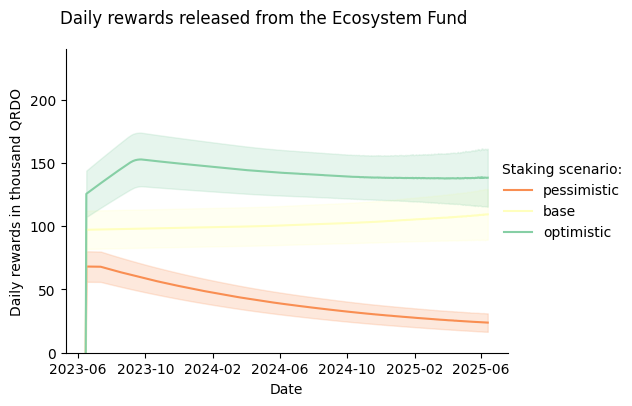

In [6]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

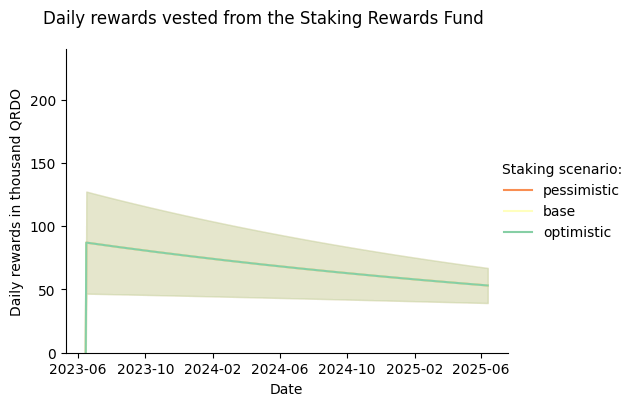

In [7]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

### 4.1 Staker APR

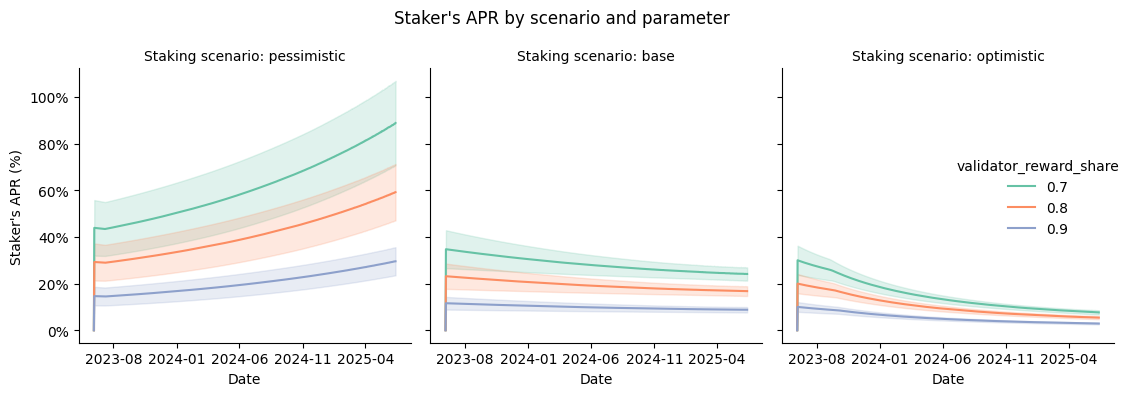

In [8]:
g = sns.relplot(data=df, x="date", y="apr", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Staker's APR (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
plt.show()

In [9]:
df.groupby(["staking_scenario", "validator_reward_share"])["apr"].mean()

staking_scenario  validator_reward_share
base              0.7                       0.282876
                  0.8                       0.193017
                  0.9                       0.098930
optimistic        0.7                       0.150241
                  0.8                       0.103726
                  0.9                       0.053805
pessimistic       0.7                       0.610659
                  0.8                       0.407115
                  0.9                       0.203554
Name: apr, dtype: float64

In [10]:
df.groupby(["validator_reward_share"])["apr"].mean().diff()

validator_reward_share
0.7         NaN
0.8   -0.113306
0.9   -0.115856
Name: apr, dtype: float64

### 4.2 Validator profit

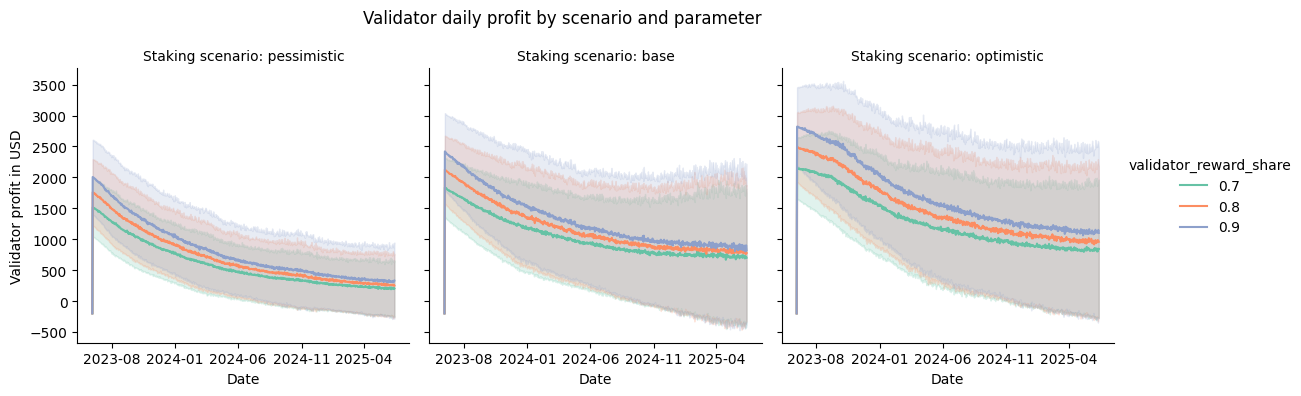

In [11]:
g = sns.relplot(data=df, x="date", y="validator_profit", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [12]:
df.groupby(["staking_scenario", "validator_reward_share"])["validator_profit"].mean()

staking_scenario  validator_reward_share
base              0.7                       1023.217593
                  0.8                       1168.841088
                  0.9                       1306.814008
optimistic        0.7                       1279.617102
                  0.8                       1489.137183
                  0.9                       1697.057491
pessimistic       0.7                        582.986758
                  0.8                        694.242759
                  0.9                        806.405188
Name: validator_profit, dtype: float64

In [13]:
df.groupby(["validator_reward_share"])["validator_profit"].mean().diff()

validator_reward_share
0.7           NaN
0.8    155.466526
0.9    152.685219
Name: validator_profit, dtype: float64

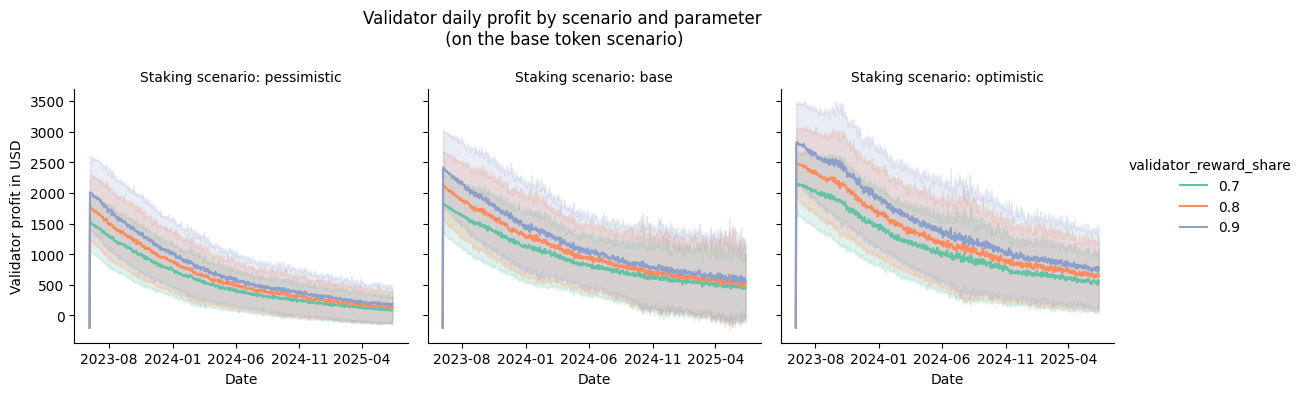

In [14]:
g = sns.relplot(data=base_df, x="date", y="validator_profit", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter\n (on the base token scenario)")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [15]:
base_df.groupby(["iteration","staking_scenario", "validator_reward_share"])["validator_profit"].mean().tail(9)

iteration  staking_scenario  validator_reward_share
729        base              0.7                       454.821585
                             0.8                       536.847817
                             0.9                       567.387692
           optimistic        0.7                       523.615870
                             0.8                       644.276248
                             0.9                       771.462983
           pessimistic       0.7                        95.551558
                             0.8                       136.039414
                             0.9                       190.807826
Name: validator_profit, dtype: float64

## 5. Parameter analysis - vesting decay rate

### 5.1 Staker APR

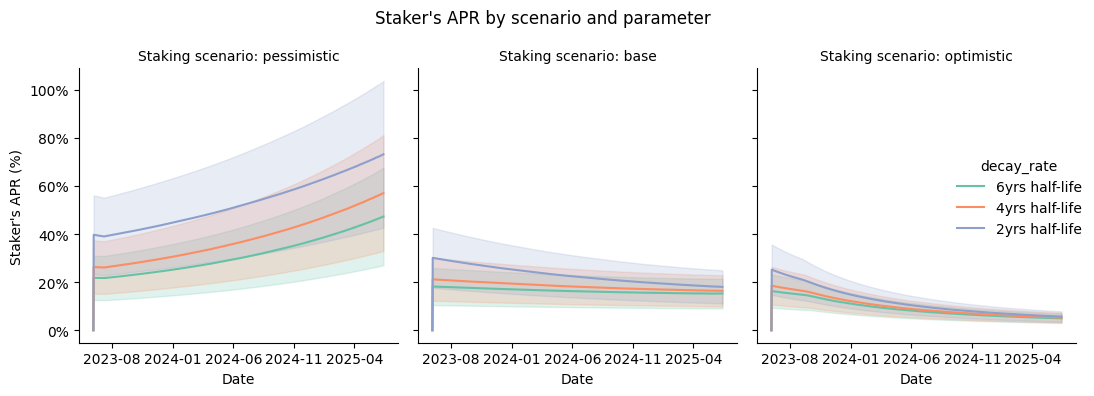

In [16]:
g = sns.relplot(data=df, x="date", y="apr", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Staker's APR (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
plt.show()

In [17]:
df.groupby(["staking_scenario", "decay_rate"])["apr"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    0.228099
                  4yrs half-life    0.183076
                  6yrs half-life    0.163648
optimistic        2yrs half-life    0.119128
                  4yrs half-life    0.098532
                  6yrs half-life    0.090113
pessimistic       2yrs half-life    0.528818
                  4yrs half-life    0.379672
                  6yrs half-life    0.312839
Name: apr, dtype: float64

In [18]:
df.groupby(["decay_rate"])["apr"].mean().diff()

decay_rate
2yrs half-life         NaN
4yrs half-life   -0.071589
6yrs half-life   -0.031560
Name: apr, dtype: float64

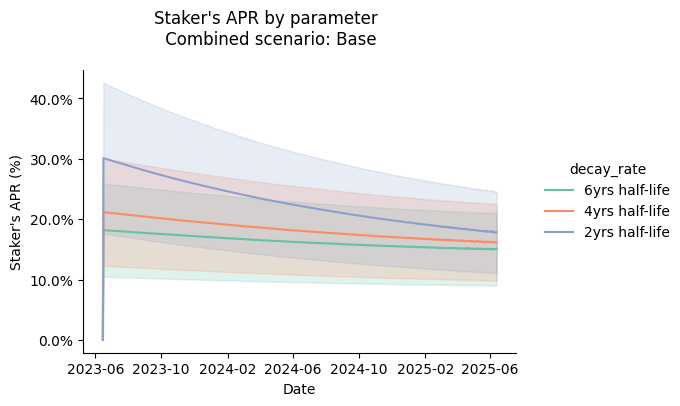

In [19]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="apr", 
                hue="decay_rate", kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by parameter \n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

### 5.2 Validator profit

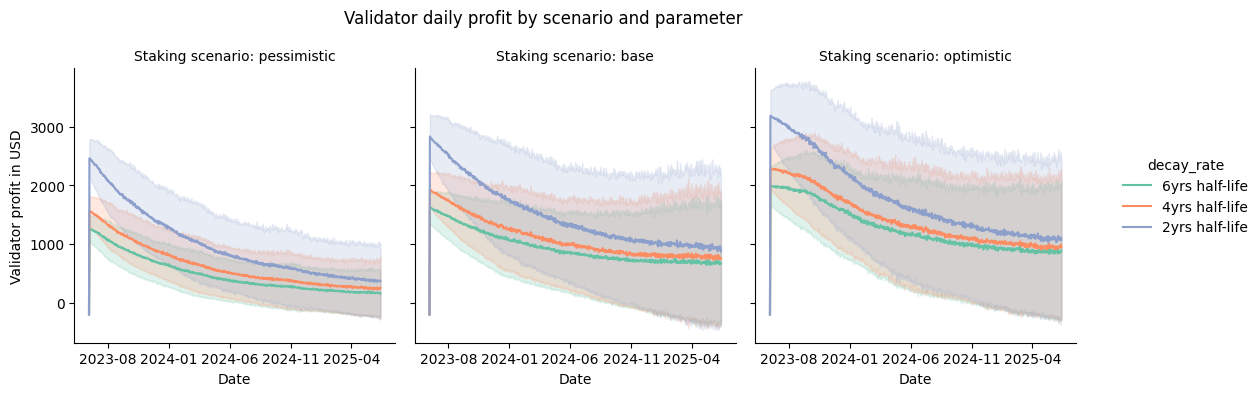

In [20]:
g = sns.relplot(data=df, x="date", y="validator_profit", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [21]:
df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    1473.008134
                  4yrs half-life    1089.896027
                  6yrs half-life     935.968528
optimistic        2yrs half-life    1781.487501
                  4yrs half-life    1416.327811
                  6yrs half-life    1267.996464
pessimistic       2yrs half-life     981.041313
                  4yrs half-life     623.822164
                  6yrs half-life     478.771228
Name: validator_profit, dtype: float64

In [22]:
df.groupby(["decay_rate"])["validator_profit"].mean().diff()

decay_rate
2yrs half-life           NaN
4yrs half-life   -368.496982
6yrs half-life   -149.103261
Name: validator_profit, dtype: float64

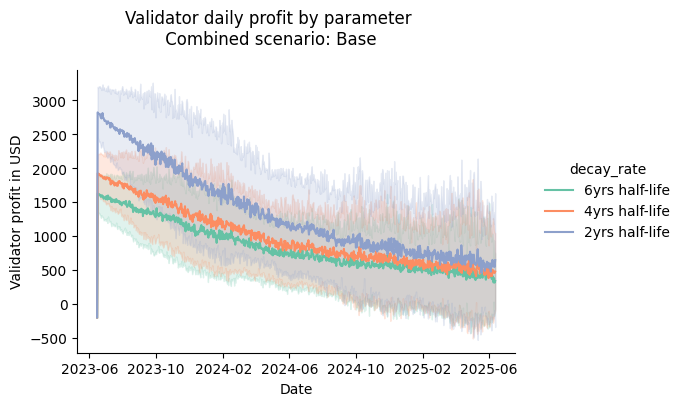

In [23]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="validator_profit", hue="decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by parameter\n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

### 5.3 Inflation rates

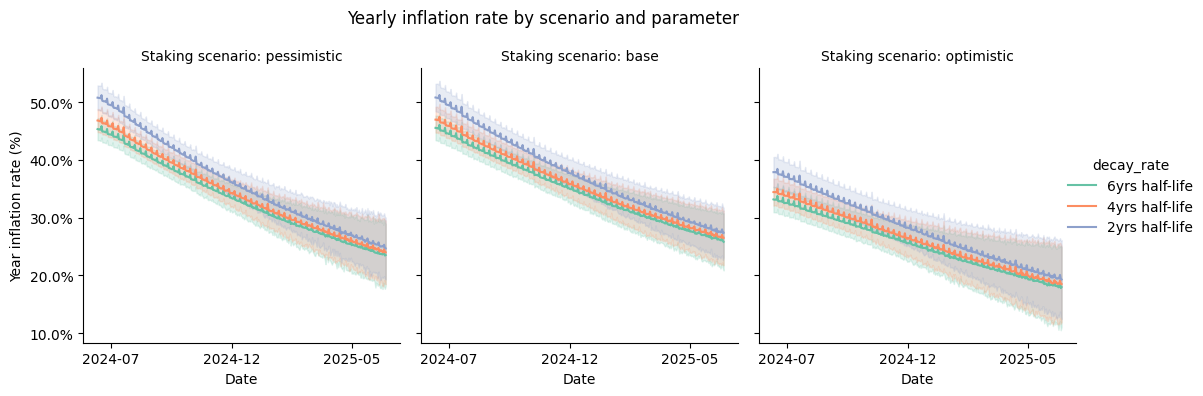

In [24]:
g = sns.relplot(data=df, x="date", y="year_inflation", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Year inflation rate (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.1, 0.5])
plt.show()

In [25]:
df.groupby(["staking_scenario", "decay_rate"])["year_inflation"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    0.377129
                  4yrs half-life    0.357613
                  6yrs half-life    0.348991
optimistic        2yrs half-life    0.280322
                  4yrs half-life    0.261479
                  6yrs half-life    0.253136
pessimistic       2yrs half-life    0.362195
                  4yrs half-life    0.342501
                  6yrs half-life    0.333707
Name: year_inflation, dtype: float64

In [26]:
df.groupby(["decay_rate"])["year_inflation"].mean().diff()

decay_rate
2yrs half-life         NaN
4yrs half-life   -0.019351
6yrs half-life   -0.008587
Name: year_inflation, dtype: float64

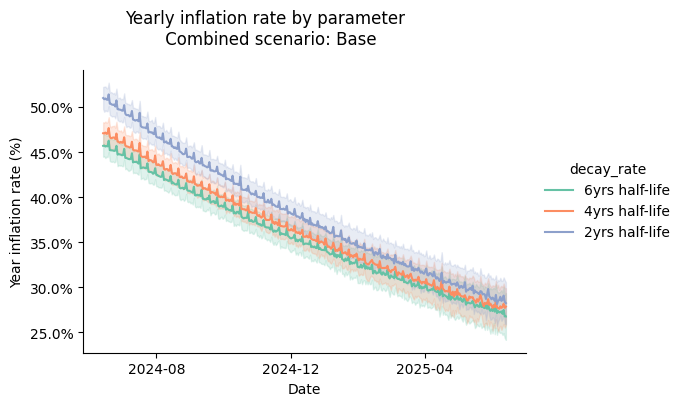

In [27]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="year_inflation", hue="decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by parameter \n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

## 6. Parameter analysis - release rate function

### 6.1 Parameter space

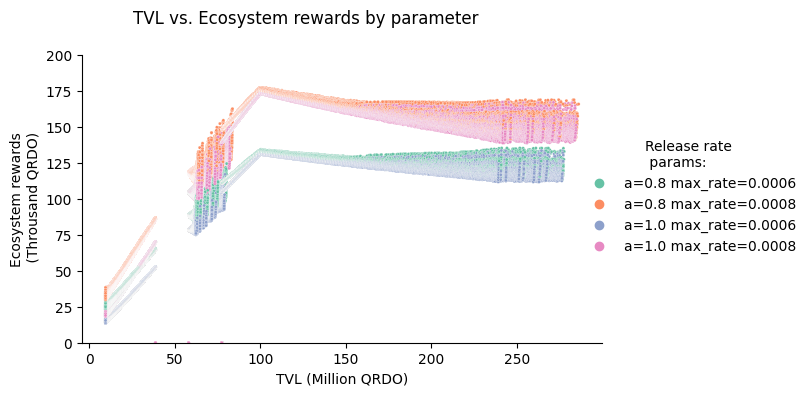

In [28]:
g = sns.relplot(data=combined_df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

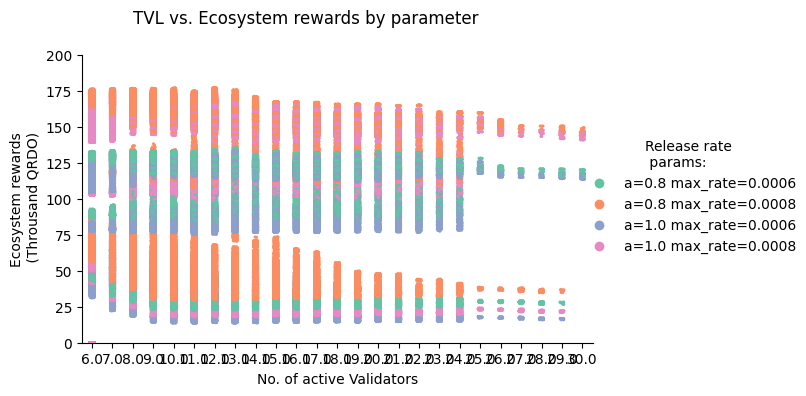

In [29]:
g = sns.catplot(data=combined_df, x="n_validators", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

### 6.2 Staker APR

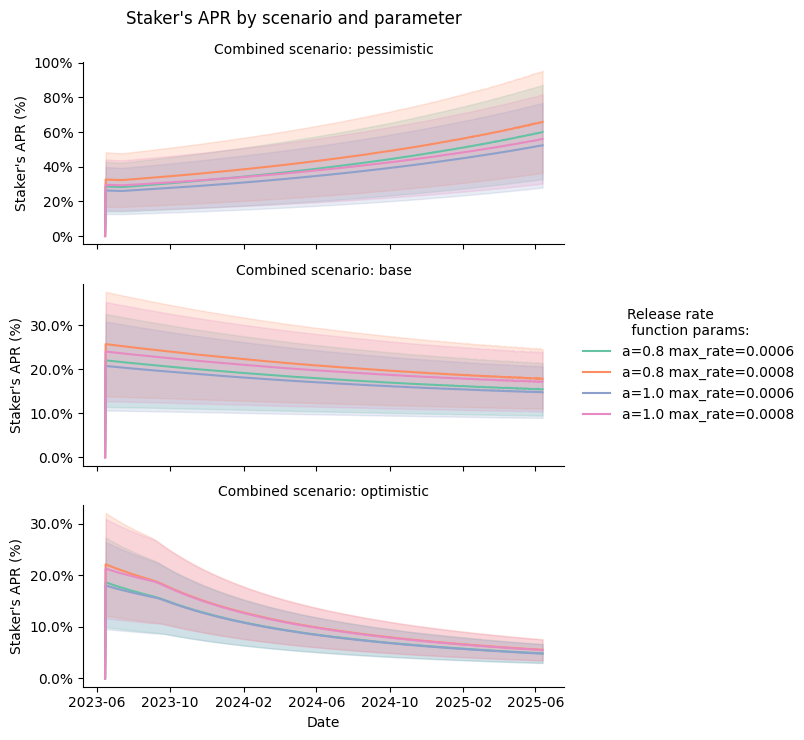

In [30]:
g = sns.relplot(data=combined_df, x="date", y="apr", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5, facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Staker's APR (%)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[1][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[2][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.35, 0.5])
plt.show()

In [31]:
combined_df.groupby(["combined_scenario", "release_rate_fn"])["apr"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    0.181444
                   a=0.8 max_rate=0.0008    0.210890
                   a=1.0 max_rate=0.0006    0.172160
                   a=1.0 max_rate=0.0008    0.199581
optimistic         a=0.8 max_rate=0.0006    0.094788
                   a=0.8 max_rate=0.0008    0.111103
                   a=1.0 max_rate=0.0006    0.093841
                   a=1.0 max_rate=0.0008    0.109949
pessimistic        a=0.8 max_rate=0.0006    0.407810
                   a=0.8 max_rate=0.0008    0.454015
                   a=1.0 max_rate=0.0006    0.363291
                   a=1.0 max_rate=0.0008    0.396000
Name: apr, dtype: float64

### 6.3 Validator Profit

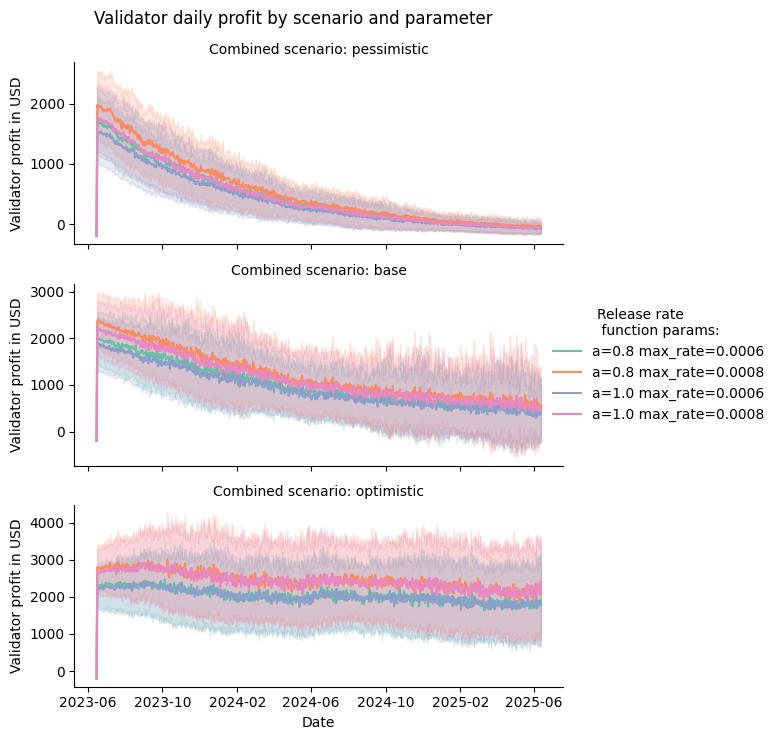

In [32]:
g = sns.relplot(data=combined_df, x="date", y="validator_profit", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5,facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Validator profit in USD")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [33]:
combined_df.groupby(["combined_scenario", "release_rate_fn"])["validator_profit"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006     990.210025
                   a=0.8 max_rate=0.0008    1197.378431
                   a=1.0 max_rate=0.0006     919.928262
                   a=1.0 max_rate=0.0008    1116.511382
optimistic         a=0.8 max_rate=0.0006    2034.096128
                   a=0.8 max_rate=0.0008    2452.422843
                   a=1.0 max_rate=0.0006    2015.963664
                   a=1.0 max_rate=0.0008    2423.876573
pessimistic        a=0.8 max_rate=0.0006     446.543933
                   a=0.8 max_rate=0.0008     528.673694
                   a=1.0 max_rate=0.0006     384.562445
                   a=1.0 max_rate=0.0008     446.686856
Name: validator_profit, dtype: float64

## 7. Parameter analysis - proposed paramaters

In [43]:
cond1 = (combined_df["validator_reward_share"]==0.8)
cond2 = (combined_df["decay_rate"]=="2yrs half-life")
cond3 = (combined_df["release_rate_fn"]=="a=0.8 max_rate=0.0006")

proposed_df = combined_df[cond1 & cond2 & cond3]

### 7.1 Staker APR

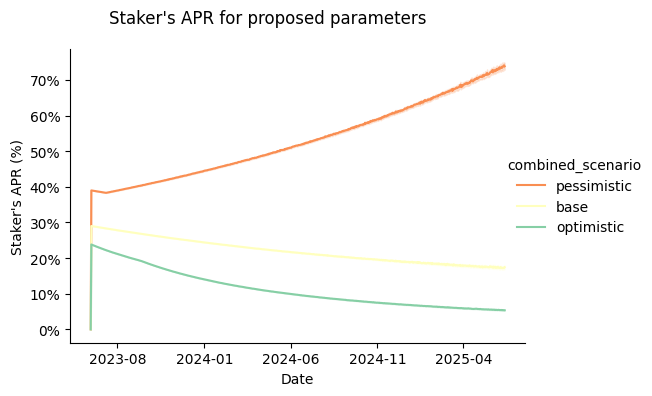

In [49]:
g = sns.relplot(data=proposed_df, x="date", y="apr", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.2, 0.5])
plt.show()

In [54]:
proposed_df.groupby(["combined_scenario"])["apr"].mean()

combined_scenario
base           0.220139
optimistic     0.112854
pessimistic    0.529508
Name: apr, dtype: float64

### 5.2 Validator profit

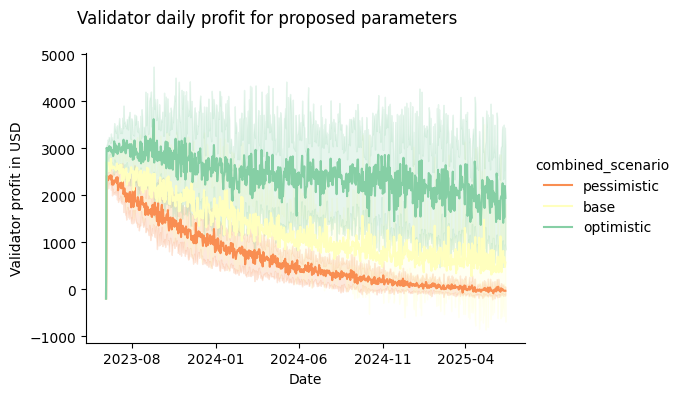

In [55]:
g = sns.relplot(data=proposed_df, x="date", y="validator_profit", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [53]:
proposed_df.groupby(["combined_scenario"])["validator_profit"].mean()

combined_scenario
base           1275.318969
optimistic     2432.106479
pessimistic     662.220315
Name: validator_profit, dtype: float64

### 5.3 Inflation rates

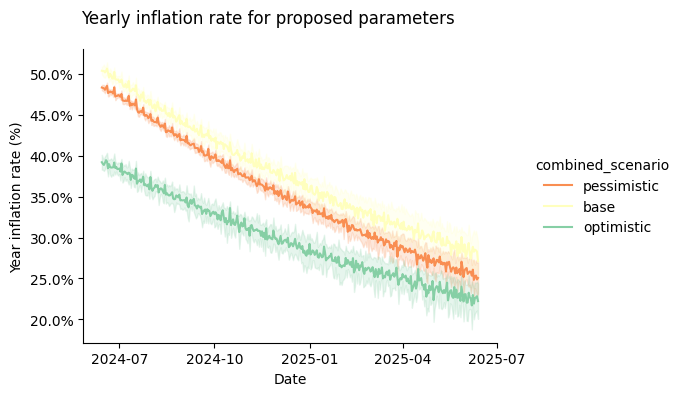

In [59]:
g = sns.relplot(data=proposed_df, x="date", y="year_inflation", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [58]:
proposed_df.groupby(["combined_scenario"])["year_inflation"].mean()

combined_scenario
base           0.378176
optimistic     0.298113
pessimistic    0.354773
Name: year_inflation, dtype: float64